In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn.metrics import accuracy_score, log_loss
import xgboost as xgb
from sklearn.model_selection import GroupKFold
plt.style.use("fivethirtyeight")
mypal = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # Grab the color pal



In [3]:
current_dir = Path().resolve()

data_dir = current_dir / 'data'
os.chdir(data_dir)


In [4]:
os.listdir()

['Cities.csv',
 'Conferences.csv',
 'MConferenceTourneyGames.csv',
 'MGameCities.csv',
 'MMasseyOrdinals.csv',
 'MNCAATourneyCompactResults.csv',
 'MNCAATourneyDetailedResults.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'MNCAATourneySeeds.csv',
 'MNCAATourneySlots.csv',
 'MRegularSeasonCompactResults.csv',
 'MRegularSeasonDetailedResults.csv',
 'MSeasons.csv',
 'MSecondaryTourneyCompactResults.csv',
 'MSecondaryTourneyTeams.csv',
 'MTeamCoaches.csv',
 'MTeamConferences.csv',
 'MTeams.csv',
 'MTeamSpellings.csv',
 'SampleSubmissionStage1.csv',
 'SampleSubmissionStage2.csv',
 'SeedBenchmarkStage1.csv',
 'WConferenceTourneyGames.csv',
 'WGameCities.csv',
 'WNCAATourneyCompactResults.csv',
 'WNCAATourneyDetailedResults.csv',
 'WNCAATourneySeeds.csv',
 'WNCAATourneySlots.csv',
 'WRegularSeasonCompactResults.csv',
 'WRegularSeasonDetailedResults.csv',
 'WSeasons.csv',
 'WSecondaryTourneyCompactResults.csv',
 'WSecondaryTourneyTeams.csv',
 'WTeamConferences.csv',
 'WTeams.csv',
 'WTeamSpellings

EDA

In [5]:
files = os.listdir(data_dir)
dataframes = {}

for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(data_dir, file)
        df_name = os.path.splitext(file)[0]
        try:
            dataframes[df_name] = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            # Try a different encoding if utf-8 fails
            dataframes[df_name] = pd.read_csv(file_path, encoding='latin1')
            
        print(f'Loaded {file} into DataFrame {df_name}')


Loaded Cities.csv into DataFrame Cities
Loaded Conferences.csv into DataFrame Conferences
Loaded MConferenceTourneyGames.csv into DataFrame MConferenceTourneyGames
Loaded MGameCities.csv into DataFrame MGameCities
Loaded MMasseyOrdinals.csv into DataFrame MMasseyOrdinals
Loaded MNCAATourneyCompactResults.csv into DataFrame MNCAATourneyCompactResults
Loaded MNCAATourneyDetailedResults.csv into DataFrame MNCAATourneyDetailedResults
Loaded MNCAATourneySeedRoundSlots.csv into DataFrame MNCAATourneySeedRoundSlots
Loaded MNCAATourneySeeds.csv into DataFrame MNCAATourneySeeds
Loaded MNCAATourneySlots.csv into DataFrame MNCAATourneySlots
Loaded MRegularSeasonCompactResults.csv into DataFrame MRegularSeasonCompactResults
Loaded MRegularSeasonDetailedResults.csv into DataFrame MRegularSeasonDetailedResults
Loaded MSeasons.csv into DataFrame MSeasons
Loaded MSecondaryTourneyCompactResults.csv into DataFrame MSecondaryTourneyCompactResults
Loaded MSecondaryTourneyTeams.csv into DataFrame MSecondar

In [6]:
print('DataFrames available: ')
for df_name in dataframes.keys():
    print(df_name)

DataFrames available: 
Cities
Conferences
MConferenceTourneyGames
MGameCities
MMasseyOrdinals
MNCAATourneyCompactResults
MNCAATourneyDetailedResults
MNCAATourneySeedRoundSlots
MNCAATourneySeeds
MNCAATourneySlots
MRegularSeasonCompactResults
MRegularSeasonDetailedResults
MSeasons
MSecondaryTourneyCompactResults
MSecondaryTourneyTeams
MTeamCoaches
MTeamConferences
MTeams
MTeamSpellings
SampleSubmissionStage1
SampleSubmissionStage2
SeedBenchmarkStage1
WConferenceTourneyGames
WGameCities
WNCAATourneyCompactResults
WNCAATourneyDetailedResults
WNCAATourneySeeds
WNCAATourneySlots
WRegularSeasonCompactResults
WRegularSeasonDetailedResults
WSeasons
WSecondaryTourneyCompactResults
WSecondaryTourneyTeams
WTeamConferences
WTeams
WTeamSpellings


In [13]:
# Concat important dataframes
df_seeds = pd.concat([dataframes['WNCAATourneySeeds'].assign(League='W'),dataframes['MNCAATourneySeeds'].assign(League='M')])

df_season_results = pd.concat([dataframes['WRegularSeasonCompactResults'].assign(League='W'),dataframes['MRegularSeasonCompactResults'].assign(League='M')])

df_tourney_results = pd.concat([dataframes['WNCAATourneyCompactResults'].assign(League='W'),dataframes['MNCAATourneyCompactResults'].assign(League='M')])


In [14]:
print("\nDescriptive statistics for Seeds:")
print(df_seeds.describe())


print("\nDescriptive statistics for Season Results:")
print(df_season_results.describe())

print("\nDescriptive statistics for Tourney Results:")
print(df_tourney_results.describe())


Descriptive statistics for Seeds:
            Season       TeamID
count  4234.000000  4234.000000
mean   2006.896316  2081.024799
std      10.621102   981.571876
min    1985.000000  1101.000000
25%    1999.000000  1266.000000
50%    2007.000000  1411.000000
75%    2016.000000  3246.000000
max    2024.000000  3465.000000

Descriptive statistics for Season Results:
              Season         DayNum        WTeamID         WScore  \
count  325732.000000  325732.000000  325732.000000  325732.000000   
mean     2008.488088      72.275592    2115.182137      74.809368   
std        10.556864      34.760327     989.479711      11.902092   
min      1985.000000       0.000000    1101.000000      30.000000   
25%      2001.000000      41.000000    1263.000000      67.000000   
50%      2009.000000      75.000000    1416.000000      74.000000   
75%      2017.000000     103.000000    3248.000000      82.000000   
max      2025.000000     132.000000    3480.000000     186.000000   

           

In [33]:
df_season_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,League
0,1998,18,3104,91,3202,41,H,0,W
1,1998,18,3163,87,3221,76,H,0,W
2,1998,18,3222,66,3261,59,H,0,W
3,1998,18,3307,69,3365,62,H,0,W
4,1998,18,3349,115,3411,35,H,0,W
...,...,...,...,...,...,...,...,...,...
190766,2025,85,1401,75,1328,68,H,0,M
190767,2025,85,1405,86,1325,83,A,0,M
190768,2025,85,1428,69,1153,66,H,0,M
190769,2025,85,1444,74,1123,71,A,0,M


In [35]:
dataframes['MNCAATourneyDetailedResults'].columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [29]:
#Make the data have 1 row for each team's game so we can aggregate

df_team_season_results = pd.concat(

    [
        df_season_results[["Season", "League", "WTeamID", "DayNum", "WScore", "LScore"]]
        .assign(GameResult="W")
        .rename(
            columns={"WTeamID": "TeamID", "WScore": "TeamScore", "LScore": "OppScore"}
        ),
        df_season_results[["Season", "League", "LTeamID", "DayNum", "WScore", "LScore"]]
        .assign(GameResult="L")
        .rename(
            columns={"LTeamID": "TeamID", "LScore": "TeamScore", "WScore": "OppScore"}
        ),
    ]
).reset_index(drop=True)

#score difference
df_team_season_results['ScoreDiff'] = df_team_season_results['TeamScore'] - df_team_season_results['OppScore']

df_team_season_results['Win'] = df_team_season_results['GameResult'].apply(lambda x: 1 if x == 'W' else 0)

In [30]:
df_team_season_results.columns

Index(['Season', 'League', 'TeamID', 'DayNum', 'TeamScore', 'OppScore',
       'GameResult', 'ScoreDiff', 'Win'],
      dtype='object')

In [31]:
team_season_agg =(
    df_team_season_results.groupby(['Season', 'League', 'TeamID']).agg(
        AvgScoreDiff = ('ScoreDiff','mean'),
        MedianScoreDiff = ('ScoreDiff','median'),
        MinScoreDiff = ('ScoreDiff','min'),
        MaxScoreDiff = ('ScoreDiff','max'),
        Wins = ('GameResult',lambda x: sum(x == 'W')),
        Losses = ('GameResult', lambda x: sum(x == 'L')),
        WinPercentage = ('Win','mean')
    ).reset_index()
)



In [32]:
team_season_agg

,Season,League,TeamID,AvgScoreDiff,MedianScoreDiff,MinScoreDiff,MaxScoreDiff,Wins,Losses,WinPercentage
0,1985,M,1102,-5.791667,-5.5,-41,29,5,19,0.208333
1,1985,M,1103,-3.043478,-2.0,-22,16,9,14,0.391304
2,1985,M,1104,7.800000,6.5,-12,25,21,9,0.700000
3,1985,M,1106,-3.791667,-1.5,-35,28,10,14,0.416667
4,1985,M,1108,7.960000,4.0,-15,35,19,6,0.760000
...,...,...,...,...,...,...,...,...,...,...
22871,2025,W,3476,-6.947368,-11.0,-45,32,8,11,0.421053
22872,2025,W,3477,-13.562500,-11.0,-49,8,2,14,0.125000
22873,2025,W,3478,-23.526316,-22.0,-69,6,2,17,0.105263
22874,2025,W,3479,-7.812500,-8.0,-44,27,4,12,0.250000


In [36]:
df_seeds

,Season,Seed,TeamID,League
0,1998,W01,3330,W
1,1998,W02,3163,W
2,1998,W03,3112,W
3,1998,W04,3301,W
4,1998,W05,3272,W
...,...,...,...,...
2553,2024,Z12,1241,M
2554,2024,Z13,1436,M
2555,2024,Z14,1324,M
2556,2024,Z15,1443,M


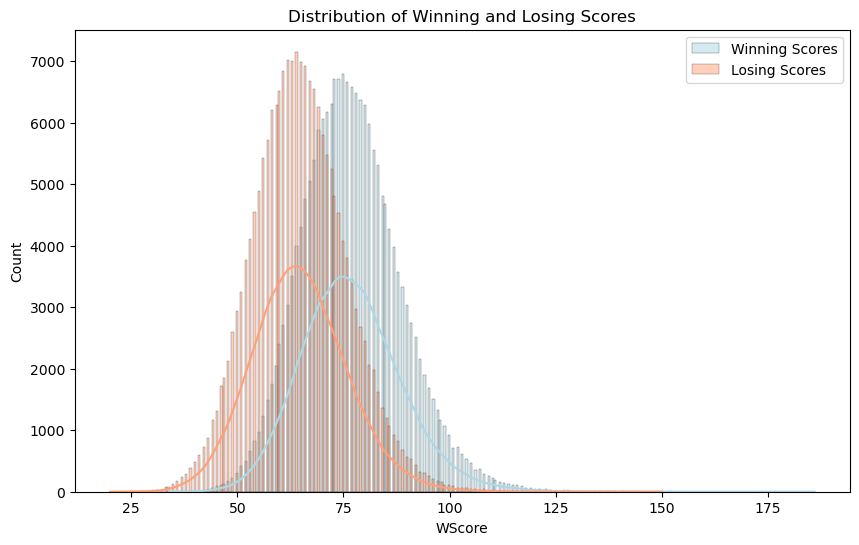

In [ ]:
plt.figure(figsize=(10, 6))

sns.histplot(dataframes['MRegularSeasonCompactResults']['WScore'], kde=True, color='#ADD8E6', label='Winning Scores', alpha=0.5) 

sns.histplot(dataframes['MRegularSeasonCompactResults']['LScore'], kde=True, color='#FFA07A', label='Losing Scores', alpha=0.5)

plt.title('Distribution of Winning and Losing Scores')
plt.legend()
plt.show()

# data seems to be normally distributed for winning/losing scores

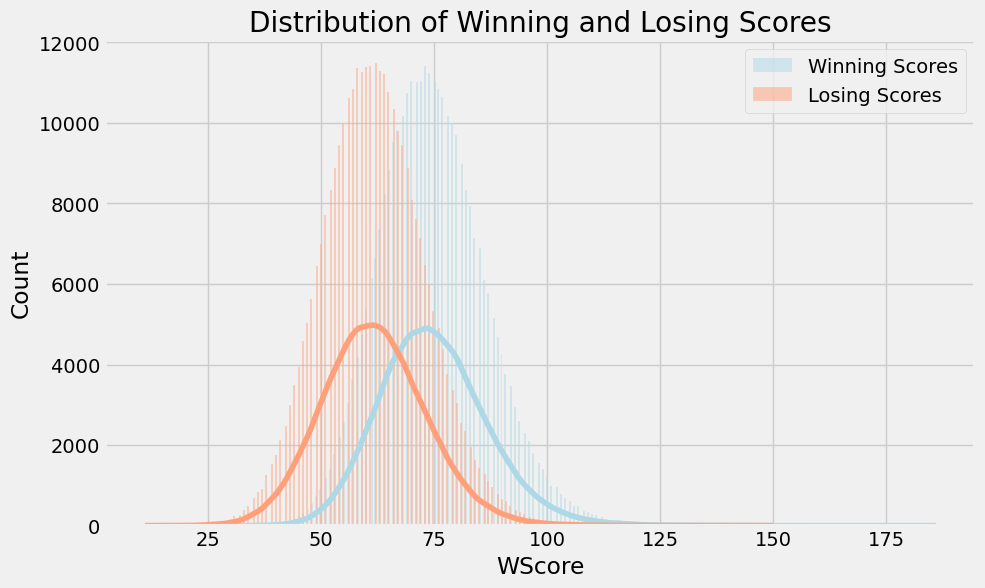

In [16]:
plt.figure(figsize=(10, 6))

sns.histplot(df_season_results['WScore'], kde=True, color='#ADD8E6', label='Winning Scores', alpha=0.5) 

sns.histplot(df_season_results['LScore'], kde=True, color='#FFA07A', label='Losing Scores', alpha=0.5)

plt.title('Distribution of Winning and Losing Scores')
plt.legend()
plt.show()

# data seems to be normally distributed for winning/losing scores

In [ ]:
#create dataframe with all scores
m_winning_scores = dataframes['MRegularSeasonCompactResults'][['WTeamID', 'WScore']].rename(columns={'WTeamID': 'TeamID', 'WScore': 'Score'})
m_losing_scores = dataframes['MRegularSeasonCompactResults'][['LTeamID', 'LScore']].rename(columns={'LTeamID': 'TeamID', 'LScore': 'Score'})
m_all_scores = pd.concat([m_winning_scores, m_losing_scores])



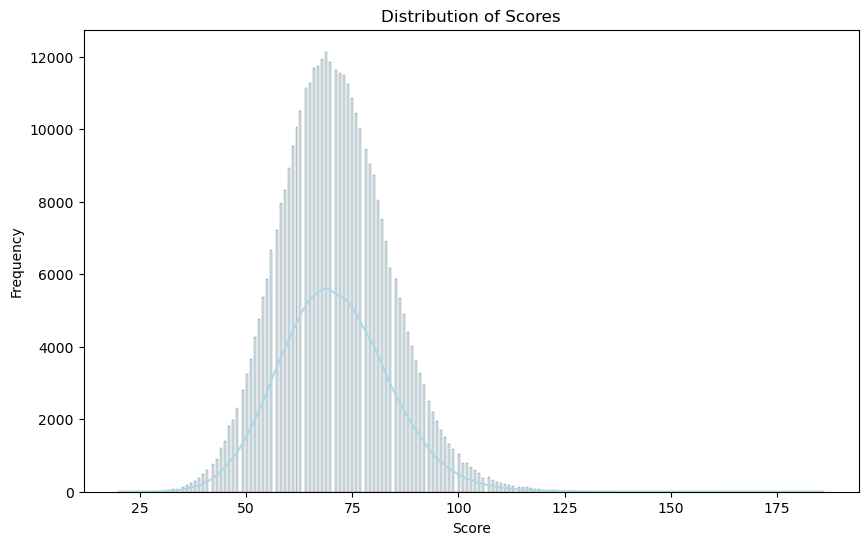

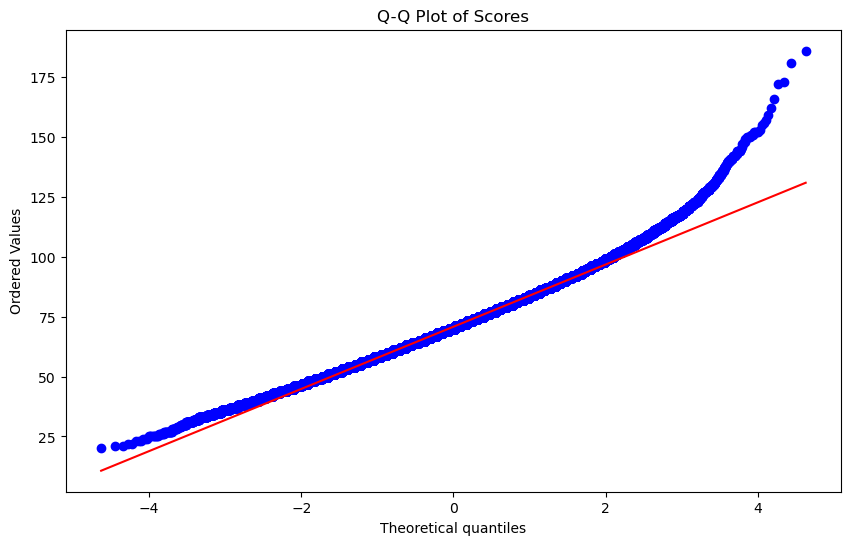

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(m_all_scores['Score'], kde=True, color='#ADD8E6')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
stats.probplot(m_all_scores['Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Scores')
plt.show()

# the scores have a heavier right tail - implying that the while most teams score within a predictable range, 
# there are some teams that score significantly higher than the average. 

In [ ]:

team_stats = m_all_scores.groupby('TeamID')['Score'].agg(['mean', 'std']).reset_index()

m_all_scores = m_all_scores.merge(team_stats, on='TeamID', how='left')

m_all_scores['StandardizedScore'] = (m_all_scores['Score'] - m_all_scores['mean']) / m_all_scores['std']

# Identify teams that consistently score above 1 standard deviation
high_scorers = m_all_scores[m_all_scores['StandardizedScore'] > 1]

# Count the number of times each team scores above 1 standard deviation
high_scorers_count = high_scorers['TeamID'].value_counts().reset_index()
high_scorers_count.columns = ['TeamID', 'HighScoreCount']

high_scorers_count = high_scorers_count.merge(dataframes['MTeams'][['TeamID', 'TeamName']], on='TeamID', how='left')


In [ ]:
# we can use this information to identify teams that are consistently high scorers. 
# And Implement as a feature in our model
high_scorers_count


,TeamID,HighScoreCount,TeamName
0,1433,219,VCU
1,1314,216,North Carolina
2,1181,209,Duke
3,1200,206,Fordham
4,1140,206,BYU
...,...,...,...
375,1118,5,Armstrong St
376,1478,5,Le Moyne
377,1327,3,Okla City
378,1479,3,Mercyhurst


In [ ]:
# average points scored by each team throughout all years


m_average_scores = m_all_scores.groupby('TeamID')['Score'].mean().reset_index()

dataframes['MTeams'] = dataframes['MTeams'].merge(m_average_scores, on='TeamID', how='left')

# dataframes['MTeams'].rename(columns={'Score': 'AvgPoints'}, inplace=True)
# print(dataframes['MTeams'].head())


   TeamID     TeamName  FirstD1Season  LastD1Season  AvgPoints
0    1101  Abilene Chr           2014          2025  69.678457
1    1102    Air Force           1985          2025  63.832727
2    1103        Akron           1985          2025  71.384747
3    1104      Alabama           1985          2025  73.227273
4    1105  Alabama A&M           2000          2025  65.863112


In [18]:
m_winning_scores_by_season = dataframes['MRegularSeasonCompactResults'][['Season', 'WTeamID', 'WScore']].rename(columns={'WTeamID': 'TeamID', 'WScore': 'Score'})
m_losing_scores_by_season = dataframes['MRegularSeasonCompactResults'][['Season', 'LTeamID', 'LScore']].rename(columns={'LTeamID': 'TeamID', 'LScore': 'Score'})
m_all_scores_by_season = pd.concat([m_winning_scores_by_season, m_losing_scores_by_season])

m_average_scores_by_season = m_all_scores_by_season.groupby(['TeamID', 'Season'])['Score'].mean().reset_index()
m_average_scores_by_season.rename(columns={'Score': 'AvgPoints'}, inplace=True)
print(m_average_scores_by_season.head())


   TeamID  Season  AvgPoints
0    1101    2014  63.142857
1    1101    2015  61.000000
2    1101    2016  69.851852
3    1101    2017  67.880000
4    1101    2018  70.666667


Features

In [51]:
# Create a binary feature indicating whether a team is a high scorer
dataframes['MTeams']['IsHighScorer'] = dataframes['MTeams']['TeamID'].isin(high_scorers_count['TeamID']).astype(int)

# Merge the high score count with the main dataset
dataframes['MTeams'] = dataframes['MTeams'].merge(high_scorers_count[['TeamID', 'HighScoreCount']], on='TeamID', how='left')

# Fill NaN values in HighScoreCount with 0 (for teams that are not high scorers)
dataframes['MTeams']['HighScoreCount'].fillna(0, inplace=True)

# Display the updated dataset
print(dataframes['MTeams'].head())


   TeamID     TeamName  FirstD1Season  LastD1Season  IsHighScorer  \
0    1101  Abilene Chr           2014          2025             1   
1    1102    Air Force           1985          2025             1   
2    1103        Akron           1985          2025             1   
3    1104      Alabama           1985          2025             1   
4    1105  Alabama A&M           2000          2025             1   

   HighScoreCount  
0              54  
1             183  
2             189  
3             182  
4              98  


Model

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load matchups from SampleSubmissionStage2
matchups = dataframes['SampleSubmissionStage2']

# Extract Season, Team1, and Team2 from the ID
matchups[['Season', 'Team1', 'Team2']] = matchups['ID'].str.split('_', expand=True)
matchups['Season'] = matchups['Season'].astype(int)
matchups['Team1'] = matchups['Team1'].astype(int)
matchups['Team2'] = matchups['Team2'].astype(int)

# Prepare historical match outcomes
historical_matches = dataframes['WRegularSeasonCompactResults']
historical_matches['Outcome'] = (historical_matches['WTeamID'] < historical_matches['LTeamID']).astype(int)
historical_matches['ID'] = historical_matches['Season'].astype(str) + '_' + historical_matches[['WTeamID', 'LTeamID']].min(axis=1).astype(str) + '_' + historical_matches[['WTeamID', 'LTeamID']].max(axis=1).astype(str)

# Merge historical outcomes with matchups
matchups = matchups.merge(historical_matches[['ID', 'Outcome']], on='ID', how='left')

# Merge high scorer features for both teams
matchups = matchups.merge(dataframes['MTeams'][['TeamID', 'IsHighScorer', 'HighScoreCount']], left_on='Team1', right_on='TeamID', how='left')
matchups = matchups.merge(dataframes['MTeams'][['TeamID', 'IsHighScorer', 'HighScoreCount']], left_on='Team2', right_on='TeamID', how='left', suffixes=('_Team1', '_Team2'))

# Calculate feature differences
matchups['IsHighScorer_Diff'] = matchups['IsHighScorer_Team1'] - matchups['IsHighScorer_Team2']
matchups['HighScoreCount_Diff'] = matchups['HighScoreCount_Team1'] - matchups['HighScoreCount_Team2']

# Fill NaN values with 0
matchups.fillna(0, inplace=True)

# Define features
features = ['IsHighScorer_Diff', 'HighScoreCount_Diff']

# Drop rows with NaN outcomes (matches without historical data)
matchups = matchups.dropna(subset=['Outcome'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(matchups[features], matchups['Outcome'], test_size=0.2, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for the test set
predictions = model.predict_proba(X_test)[:, 1]

# Create the submission format
submission = matchups[['ID']].iloc[X_test.index].copy()
submission['Pred'] = predictions

# Display the submission
print(submission)

                    ID      Pred
93591   2025_3194_3292  0.026054
40386   2025_1245_1452  0.000000
122649  2025_3341_3420  0.026054
66531   2025_3102_3212  0.026054
41294   2025_1249_1462  0.000000
...                ...       ...
97846   2025_3210_3277  0.026054
56719   2025_1338_1450  0.000000
53328   2025_1314_1463  0.000000
78261   2025_3141_3286  0.026054
26945   2025_1190_1417  0.000000

[26301 rows x 2 columns]
